In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline # importing all the libraries

In [2]:
import glob

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpoints = [] 
imgpoints = [] # getting objectpoints and imagepoints for camera calibration

images = glob.glob('camera_cal/calibration*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
  
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret) # drawing chessboard corners


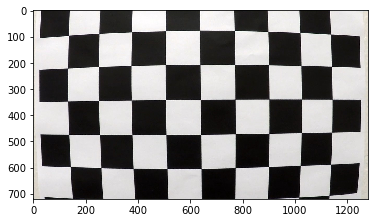

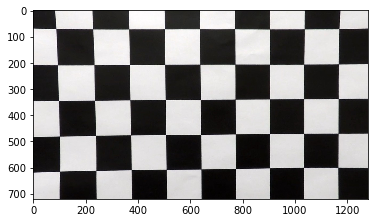

In [3]:
imgage_new = mpimg.imread('camera_cal/calibration1.jpg')

def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

undistorted = cal_undistort(imgage_new, objpoints, imgpoints) # Calling function to undistort image
plt.figure()
plt.imshow(imgage_new)
plt.figure()
plt.imshow(undistorted)

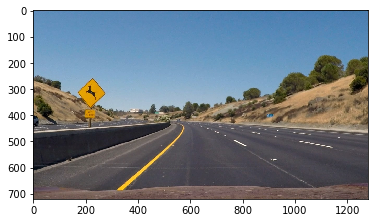

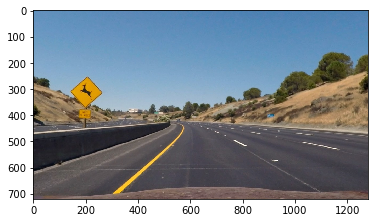

In [4]:
image_new2 = mpimg.imread('test_images/test2.jpg')
undistorted2 = cal_undistort(image_new2, objpoints, imgpoints) # Undistorting one of the test image
plt.figure()
plt.imshow(image_new2)
plt.figure()
plt.imshow(undistorted2)

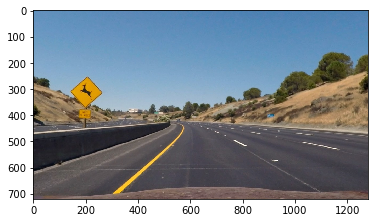

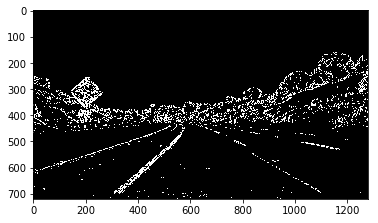

In [5]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255): 
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(gray)
    binary_output[(scaled_sobel>=thresh_min)&(scaled_sobel<=thresh_max)] = 1
    return binary_output
    
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))

    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=mag_thresh[0])&(scaled_sobel<=mag_thresh[1])] = 1

    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.5)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx =  np.absolute(sobelx) 
    abs_sobely =  np.absolute(sobely) 
    G_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output = np.zeros_like(gray)
    binary_output[(G_dir>=thresh[0])&(G_dir<=thresh[1])] = 1
    
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S>thresh[0])&(S<=thresh[1])] =1

    return binary_output
    
ksize = 3
gradx = abs_sobel_thresh(undistorted2, orient='x', thresh_min=20, thresh_max=100)
grady = abs_sobel_thresh(undistorted2, orient='y', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(undistorted2, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(undistorted2, sobel_kernel=ksize, thresh=(0.7, 1.5))  
hls_binary = hls_select(undistorted2, thresh=(170, 255))


combined = np.zeros_like(dir_binary)
combined[(((hls_binary == 1) & (dir_binary == 1)) | (gradx == 1))] = 1 # Combining different threshholds output to get binary output of lane lines

plt.figure()
plt.imshow(undistorted2)
plt.figure()
plt.imshow(combined, cmap = 'gray')

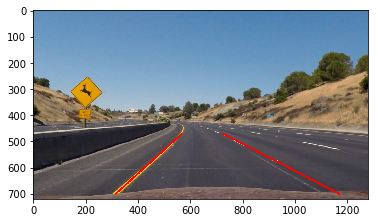

In [6]:
undistorted3 = np.copy(undistorted2)
im1 = cv2.line(undistorted3,(315,700),(570,470),(255,0,0),5)
im2= cv2.line(im1,(1170,700),(725,470),(255,0,0),5) # trying to fit 2 lines on lane lines to get source points for warping function

plt.figure()
plt.imshow(im2)

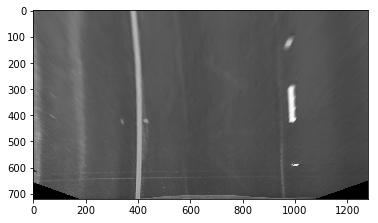

In [7]:
def warp(img): # Defining warping function with source and destination points
    src = np.float32([[315,700],[570,470],[1170,700],[725,470] ])
    dst = np.float32([[400,720],[400,0],[1000,720],[1000,0]])
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def unwarp(img):  # Defining unwarping function with source and destination points
    src = np.float32([[315,700],[570,470],[1170,700],[725,470] ])
    dst = np.float32([[400,720],[400,0],[1000,720],[1000,0]])
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unwarped

gray1 = cv2.cvtColor(undistorted2, cv2.COLOR_BGR2GRAY)
warped_image = warp(gray1)
plt.figure()
plt.imshow(warped_image,cmap='gray') # Testing warping on an image

(720, 1280)

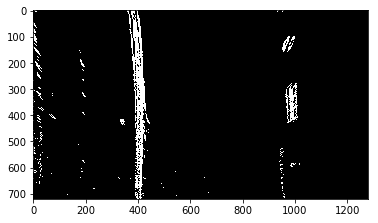

In [8]:
combined2 = np.copy(combined)
WTI = warp(combined2)
plt.figure()
plt.imshow(WTI,cmap='gray')
WTI.shape

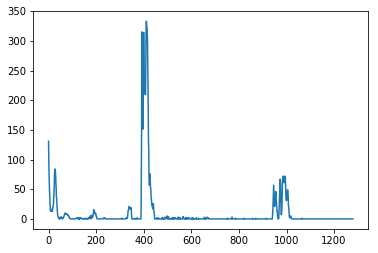

In [9]:
import numpy as np
histogram = np.sum(WTI[WTI.shape[0]//2:,:], axis=0)
plt.plot(histogram) # Histogram of binary warped image for lane detection

In [10]:

def search_window(image): # Defining function to find lane lines using histogram peak values
    
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[100:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(image.shape[0]/nwindows)
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
         
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    return left_lane_inds, right_lane_inds
left_lane_inds, right_lane_inds= search_window(WTI)
print(len(left_lane_inds))
print(len(right_lane_inds))


19931
5974


In [11]:
def pipeline(image): # Defining Pipeline for video 
    undist = cal_undistort(image, objpoints, imgpoints) # undistorting image
    gradx = abs_sobel_thresh(undist, orient='x', thresh_min=40, thresh_max=120)
    dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.9, 1.5))  
    hls_binary = hls_select(undist, thresh=(100, 255)) # applying thresholds and getting binary outputs
    combined = np.zeros_like(dir_binary)
    combined[(((hls_binary == 1) & (dir_binary == 1)) | (gradx == 1))] = 1 # Combining binary outputs to get lane lines 
    Warped = warp(combined) # Warping image
    left_i, right_i = [], [] # Defining matrices to store lines to get average over past 10 iterations
    if pipeline.counter==0 : # Starting with finding lane lines with search window function
        left_lane_inds, right_lane_inds = search_window(Warped)
        nonzero = Warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        pipeline.counter = 1
        pipeline.left_fit = left_fit
        pipeline.right_fit = right_fit  # Storing left fit and right fit values to be used for second image
    else:
        left_fit = pipeline.left_fit
        right_fit = pipeline.right_fit # using left fit and right fit from search window function
        nonzero = Warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        # Finding left and right lane indices
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        
        # If points detected less than 31000, again find points using search window function
        if len(left_lane_inds)+len(right_lane_inds)<31000:
            pipeline.counter = 0
        
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2) # Finding left fit and right fit matrices
    
    
    left_i.append(left_fit)
    right_i.append(right_fit) # appending them to get mean value over past 9 frames
    if len(left_i)>=9:
        left_fit = np.mean(left_i[-1:-8:-1])
        right_fit = np.mean(right_i[-1:-8:-1])

    ploty = np.linspace(0, Warped.shape[0]-1, Warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] # finding x values of lines using y values and fit functions
    
    warp_zero = np.zeros_like(Warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # unWarp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = unwarp(color_warp) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    y_eval = 719
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # finding left and right curvature of line
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Taking mean of curvatures
    rad=np.mean([left_curverad,right_curverad])
    # Finding mid point of road
    mid=np.mean((left_fit[0]*y_eval**2+left_fit[1]*y_eval+left_fit[2],right_fit[0]*y_eval**2+right_fit[1]*y_eval+right_fit[2]))
    imageT  = np.copy(result)
    # adding text to image contining curve radius
    texted =cv2.putText(img=imageT, text="curve radius={0:.2f} m".format(rad), org=(200,100),fontFace=3, fontScale=1, color=(255,255,255), thickness=3)
    # finding offset of camera
    camera = (mid-700)*xm_per_pix 
    if camera<=0:
        T = "left"
    else: 
        T = "right"
    imageT2  = np.copy(texted)
    # Inserting text with distance from center
    texted2 =cv2.putText(img=imageT2, text="Distance from center={0:.2f} m {1:}".format(abs(camera),T), org=(200,150),fontFace=3, fontScale=1, color=(255,255,255), thickness=3)

    return texted2
pipeline.counter = 0
pipeline.left_fit = []
pipeline.right_fit = []


In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'project4_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project4_video.mp4
[MoviePy] Writing video project4_video.mp4


100%|█████████▉| 1260/1261 [18:28<00:00,  1.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project4_video.mp4 

CPU times: user 21min 44s, sys: 8.64 s, total: 21min 53s
Wall time: 18min 29s
